In [ ]:
# !pip install optuna
!pip install keras-rectified-adam
!pip install unidecode
!pip install contractions

In [ ]:
from bs4 import BeautifulSoup 
import unidecode
import contractions
from gensim.parsing.preprocessing import remove_stopwords
import re
from nltk.stem.porter import PorterStemmer

def preprocessing(text):
  ### Removed HTML Tags - <> ###
  text = BeautifulSoup(text, 'html.parser')
  text = text.get_text(separator=' ')
  ### Convert Accented Characters ###
  text = unidecode.unidecode(text)
  ### Expand Contractions - don't ###
  text = contractions.fix(text)
  ### Removed Stopwords ###
  text = remove_stopwords(text)
  ### Removed URL ###
  text = re.sub(r'http\S+', '', text)
  ### Removed All Irrelevant Characters ###
  text = re.sub('[^a-zA-Z]', ' ', text)
  ### Convert All Characters into lowercase  ###
  text = text.lower()
  ### Removed not less than 2 words ###
  text = [word for word in text.split() if len(word) > 3]
  ### Stemming ###
  stemmer = PorterStemmer()
  text = [stemmer.stem(word) for word in text]
  ### Concated ###
  cleaned_text = ' '.join(text)
  
  return cleaned_text

In [ ]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/SIGNATE/DATASET/train.csv'
TEST_PATH = '/content/drive/MyDrive/SIGNATE/DATASET/test.csv'

BATCH_SIZE = 32
EPOCHS = 10
VALIDATION_SPLIT = 0.1

In [ ]:
import pandas as pd

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

Y_train = df_train['state'].astype(int).values
df_train = df_train.drop('state', axis=1)
test_id = df_test['id']

# train_html = df_train['html_content'].apply(preprocessing).values
# test_html = df_test['html_content'].apply(preprocessing).values
# data_html = pd.concat([df_train['html_content'], df_test['html_content']], axis=0).apply(preprocessing)

train_html = df_train['html_content'].values
test_html = df_test['html_content'].values
data_html = pd.concat([df_train['html_content'], df_test['html_content']], axis=0)

df_train = df_train.drop('html_content', axis=1)
df_test = df_test.drop('html_content', axis=1)
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

df = pd.concat([df_train, df_test], axis=0)

print('train_html shape: {0}'.format(train_html.shape))
print('test_html shape: {0}'.format(test_html.shape))
print('data_html shape: {0}'.format(data_html.shape))

train_html shape: (10545,)
test_html shape: (10544,)
data_html shape: (21089,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

train_data = np.empty((len(df_train), 0), int)
test_data = np.empty((len(df_test), 0), int)

for column in df.columns:
  one_hot_encoder = OneHotEncoder(sparse=False)
  one_hot_encoder.fit(df[column].values.reshape(-1, 1))
  train_temp = one_hot_encoder.transform(df_train[column].values.reshape(-1, 1))
  test_temp = one_hot_encoder.transform(df_test[column].values.reshape(-1, 1))
  train_data = np.concatenate([train_data, train_temp], axis=1)
  test_data = np.concatenate([test_data, test_temp], axis=1)

print('train_data: {0}'.format(train_data.shape))
print('test_data: {0}'.format(test_data.shape))

train_data: (10545, 359)
test_data: (10544, 359)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tokenizer = TfidfVectorizer(max_features=200)

tfidf = tokenizer.fit(data_html)

train_html = tfidf.transform(train_html)
test_html = tfidf.transform(test_html)

train_html = train_html.toarray()
test_html = test_html.toarray()

print('train_html: {0}'.format(train_html.shape))
print('test_html: {0}'.format(test_html.shape))
print('train_html type: {0}'.format(type(train_html)))
print('test_html type: {0}'.format(type(test_html)))

train_html: (10545, 200)
test_html: (10544, 200)
train_html type: <class 'numpy.ndarray'>
test_html type: <class 'numpy.ndarray'>


In [ ]:
# train_data = np.concatenate([train_html, train_data], axis=1)
# test_data = np.concatenate([test_html, test_data], axis=1)

# print('train_data: {0}'.format(train_data.shape))
# print('test_data: {0}'.format(test_data.shape))

from sklearn import preprocessing

mm = preprocessing.MinMaxScaler()

mm.fit(train_data)
mm.fit(test_data)

train_data = mm.transform(train_data)
test_data = mm.transform(test_data)

print('train_data: {0}'.format(train_data.shape))
print('test_data: {0}'.format(test_data.shape))

train_data: (10545, 359)
test_data: (10544, 359)


In [ ]:
from keras.models import Model
from keras import Input
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, concatenate
from keras.optimizers import Adagrad, RMSprop, SGD, Adam, Adadelta
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras_radam import RAdam
import tensorflow_addons as tfa

dropout_rate = 0.2

tfidf_input = Input(shape=(200,))
x = Dropout(dropout_rate)(tfidf_input)
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_rate)(x)
tfidf_model = Dense(64, activation='relu')(x)

nn_input = Input(shape=(359,))
y = Dropout(dropout_rate)(nn_input)
y = Dense(64, activation='relu')(y)
y = Dropout(dropout_rate)(y)
y = Dense(64, activation='relu')(y)
y = Dropout(dropout_rate)(y)
nn_model = Dense(64, activation='relu')(y)

concatenated = concatenate([tfidf_model, nn_model], axis=-1)

output = Dense(1, activation='sigmoid')(concatenated)

model = Model([tfidf_input, nn_input], output)

model.compile(optimizer=tfa.optimizers.RectifiedAdam(total_steps=10000, warmup_proportion=0.1, min_lr=1e-5), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

# model.summary()

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import RMSprop, Adagrad, SGD
# from keras.losses import binary_crossentropy
# from keras.metrics import binary_accuracy

# model = Sequential()

# model.add(Dense(32, activation='relu', input_shape=(659,)))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=RMSprop(lr=1e-3), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

In [ ]:
from keras.callbacks import ModelCheckpoint

history = model.fit([train_html, train_data], Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)
# history = model.fit([train_html, train_data], Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
# history = model.fit(train_data, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/10
297/297 [==============================] - 6s 6ms/step - loss: 0.6943 - binary_accuracy: 0.4834 - f1_score: 0.4813 - val_loss: 0.6892 - val_binary_accuracy: 0.5953 - val_f1_score: 0.6276
Epoch 2/10
297/297 [==============================] - 1s 5ms/step - loss: 0.6809 - binary_accuracy: 0.5989 - f1_score: 0.6358 - val_loss: 0.5909 - val_binary_accuracy: 0.6995 - val_f1_score: 0.7135
Epoch 3/10
297/297 [==============================] - 1s 4ms/step - loss: 0.5541 - binary_accuracy: 0.7187 - f1_score: 0.7166 - val_loss: 0.4821 - val_binary_accuracy: 0.7602 - val_f1_score: 0.7734
Epoch 4/10
297/297 [==============================] - 1s 4ms/step - loss: 0.4860 - binary_accuracy: 0.7531 - f1_score: 0.7501 - val_loss: 0.4581 - val_binary_accuracy: 0.7773 - val_f1_score: 0.7836
Epoch 5/10
297/297 [==============================] - 1s 4ms/step - loss: 0.4527 - binary_accuracy: 0.7818 - f1_score: 0.7777 - val_loss: 0.4454 - val_binary_accuracy: 0.7754 - val_f1_score: 0.7561
Epoch 6/10

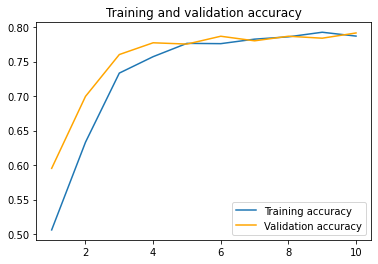

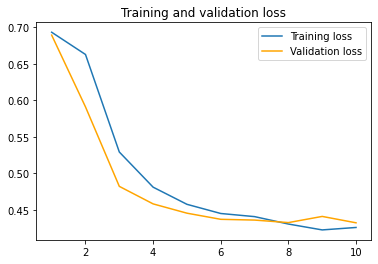

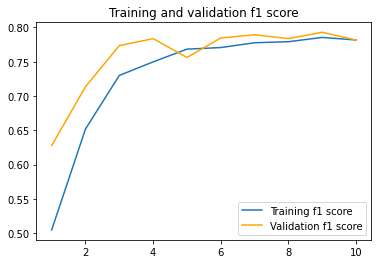

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(1, EPOCHS+1)

plt.plot(epochs, acc, linestyle='solid', label='Training accuracy')
plt.plot(epochs, val_acc, linestyle='solid', color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, linestyle='solid', color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
plt.plot(epochs, f1, linestyle='solid', label='Training f1 score')
plt.plot(epochs, val_f1, linestyle='solid', color='orange', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend()

plt.show()

In [ ]:
# # from keras.models import load_model
# import numpy as np

# # model = load_model('/content/drive/MyDrive/SIGNATE/DATASET/LSTM_AND_NN.h5', custom_objects={'f1_score': f1_score})

predicted_01 = model.predict([test_html, test_data])
# # predicted = model.predict(test_data)

# # df_sub = pd.concat([test_id, predicted, columns=['predicted']).astype(int)], axis=1)

# df_sub = pd.concat([test_id, pd.DataFrame(np.round(predicted), columns=['predicted']).astype(int)], axis=1)

# print('df_sub shape: {0}'.format(df_sub.shape))

# # df_sub.to_csv('/content/drive/MyDrive/SIGNATE/DATASET/submission.csv', index=False, header=False)
# # df_sub.to_csv('submission.csv', index=False, header=False)

# df_sub.head()

In [ ]:
train_data = np.concatenate([train_html, train_data], axis=1)
test_data = np.concatenate([test_html, test_data], axis=1)

print('train_data: {0}'.format(train_data.shape))
print('test_data: {0}'.format(test_data.shape))

train_data: (10545, 559)
test_data: (10544, 559)


In [ ]:
# import optuna
from sklearn.model_selection import cross_val_score
from sklearn import svm
import lightgbm as lgb

clf_svm = svm.SVC(kernel='rbf', C=1000, gamma=1e-3)
clf_lgb = lgb.LGBMClassifier(n_estimators = 10000, objective = 'binary', learning_rate = 0.001, num_leaves = 100, random_state = 2021, n_jobs = -1, importance_type = 'gain', colsample_bytree = 0.5, reg_lambda = 5)
# scores = cross_val_score(model, train_data, Y_train, scoring='f1', cv=10)

# print('f1 score: {0}'.format(scores))
# print('f1 score mean: {0}'.format(scores.mean()))
# print('f1 score std: {0}'.format(scores.std()))

clf_svm.fit(train_data, Y_train)
clf_lgb.fit(train_data, Y_train)

In [21]:
predicted_svm = clf_svm.predict(test_data)
predicted_lgb = clf_lgb.predict(test_data)

# df_sub_01 = pd.concat([test_id, pd.DataFrame(predicted_01, columns=['predicted'])], axis=1)
df_sub_01 = pd.concat([test_id, pd.DataFrame(np.round(predicted_01), columns=['predicted']).astype(int)], axis=1)
df_sub_svm = pd.concat([test_id, pd.DataFrame(predicted_svm, columns=['predicted']).astype(int)], axis=1)
df_sub_lgb = pd.concat([test_id, pd.DataFrame(predicted_lgb, columns=['predicted']).astype(int)], axis=1)

# df_sub = pd.concat([df_sub_01['id'], pd.DataFrame(np.round(df_sub_01['predicted'].values*0.25+df_sub_svm['predicted'].values*0.25+df_sub_lgb['predicted'].values*0.5)).astype(int)], axis=1)

# df_sub.to_csv('submission.csv', index=False, header=False)
df_sub_01.to_csv('submission_nn.csv', index=False, header=False)
df_sub_svm.to_csv('submission_svm.csv', index=False, header=False)
df_sub_lgb.to_csv('submission_lgb.csv', index=False, header=False)

In [ ]:
# df_sub.head()

In [23]:
df_sub_01.head()

,id,predicted
0,10545,1
1,10546,1
2,10547,1
3,10548,0
4,10549,0


In [24]:
df_sub_svm.head()

,id,predicted
0,10545,1
1,10546,1
2,10547,1
3,10548,0
4,10549,0


In [25]:
df_sub_lgb.head()

,id,predicted
0,10545,1
1,10546,1
2,10547,1
3,10548,0
4,10549,0
